<a href="https://colab.research.google.com/github/jeffheaton/present/blob/master/WUSTL/CABI-Demand/demand_naive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Washington University [Olin School of Business](https://olin.wustl.edu/EN-US/Pages/default.aspx)
[Center for Analytics and Business Insights](https://olin.wustl.edu/EN-US/Faculty-Research/research-centers/center-analytics-business-insights/Pages/default.aspx) (CABI)  
[Deep Learning for Demand Forecasting](https://github.com/jeffheaton/present/tree/master/WUSTL/CABI-Demand)  
Copyright 2022 by [Jeff Heaton](https://www.youtube.com/c/HeatonResearch), Released under [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) 

## Simple Univariate Projection

First map Google drive.

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


Load the three data files.

In [2]:
import pandas as pd
import os

PATH = "/content/drive/MyDrive/projects/demand/"

df_sales = pd.read_csv("https://data.heatonresearch.com/wustl/CABI/demand-forecast/sales_train.csv", parse_dates=['date'])
df_items = pd.read_csv("https://data.heatonresearch.com/wustl/CABI/demand-forecast/items.csv")
df_resturant = pd.read_csv("https://data.heatonresearch.com/wustl/CABI/demand-forecast/resturants.csv")

Utility function to create sequences.

In [3]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Join the items and sales tables so that we can look up the store id for each item.

In [4]:
df_items2 = df_items[['id','store_id']]
df_train = df_sales.merge(df_items2,left_on='item_id',right_on='id')
df_train[['date','item_id','item_count','store_id']]

df_train = df_train.sort_values('date').groupby(['item_id', 'store_id', 'date'], as_index=False)
df_train = df_train.agg({'item_count':['mean']})
df_train.columns = ['item', 'store', 'date', 'sales']
df_train.head()

,item,store,date,sales
0,1,4,2020-01-01,0.0
1,1,4,2020-01-02,0.0
2,1,4,2020-01-03,0.0
3,1,4,2020-01-04,0.0
4,1,4,2020-01-05,0.0


Build the sequence data.

In [5]:
window = 29
future_span = 30
series = series_to_supervised(df_train.drop('date', axis=1), window=window, lag=future_span)
series.head()

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+30),store(t+30),sales(t+30)
29,1.0,4.0,0.0,1.0,4.0,0.0,1.0,4.0,0.0,1.0,...,0.0,1.0,4.0,0.0,1,4,0.0,1.0,4.0,0.0
30,1.0,4.0,0.0,1.0,4.0,0.0,1.0,4.0,0.0,1.0,...,0.0,1.0,4.0,0.0,1,4,0.0,1.0,4.0,0.0
31,1.0,4.0,0.0,1.0,4.0,0.0,1.0,4.0,0.0,1.0,...,0.0,1.0,4.0,0.0,1,4,0.0,1.0,4.0,0.0
32,1.0,4.0,0.0,1.0,4.0,0.0,1.0,4.0,0.0,1.0,...,0.0,1.0,4.0,0.0,1,4,0.0,1.0,4.0,0.0
33,1.0,4.0,0.0,1.0,4.0,0.0,1.0,4.0,0.0,1.0,...,0.0,1.0,4.0,0.0,1,4,0.0,1.0,4.0,0.0


Remove sequences that did not have enough data.

In [6]:
# Remove edge cases, where there were not enough values to complete a series
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

We will just predict using the sales column.

In [7]:
# Remove all but the sales column
columns_to_drop = [('%s(t+%d)' % (col, future_span)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

Extract the predictors (x sequences) and the label (future prediction)

In [8]:
from sklearn.model_selection import train_test_split

# Label
labels_col = 'sales(t+%d)' % future_span
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (42102, 30)
Validation set shape (28068, 30)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
67683,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
25424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Final preparation for the x and y.

In [9]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (42102, 30, 1)
Validation set shape (28068, 30, 1)


Construct the neural network.

In [10]:
import tensorflow as tf 
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout
import keras

epochs = 500 
batch = 256
lr = 0.0003
adam = tf.keras.optimizers.Adam(lr)

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=8, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 23, 64)            576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 11, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 704)               0         
                                                                 
 dense (Dense)               (None, 50)                35250     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                        

Fit the neural network.

In [11]:
from keras.callbacks import EarlyStopping

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, 
        verbose=1, mode='auto', restore_best_weights=True)

cnn_history = model_cnn.fit(X_train_series, Y_train, callbacks=[monitor],
    validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/500
1316/1316 - 13s - loss: 162.2233 - val_loss: 124.5213 - 13s/epoch - 10ms/step
Epoch 2/500
1316/1316 - 5s - loss: 142.3151 - val_loss: 120.3344 - 5s/epoch - 3ms/step
Epoch 3/500
1316/1316 - 6s - loss: 133.3426 - val_loss: 116.9485 - 6s/epoch - 4ms/step
Epoch 4/500
1316/1316 - 8s - loss: 132.2887 - val_loss: 115.1061 - 8s/epoch - 6ms/step
Epoch 5/500
1316/1316 - 5s - loss: 140.0431 - val_loss: 114.1779 - 5s/epoch - 3ms/step
Epoch 6/500
1316/1316 - 6s - loss: 130.3924 - val_loss: 112.3122 - 6s/epoch - 4ms/step
Epoch 7/500
1316/1316 - 8s - loss: 130.4476 - val_loss: 110.6966 - 8s/epoch - 6ms/step
Epoch 8/500
1316/1316 - 5s - loss: 120.4870 - val_loss: 117.9689 - 5s/epoch - 4ms/step
Epoch 9/500
1316/1316 - 6s - loss: 126.8215 - val_loss: 113.3401 - 6s/epoch - 4ms/step
Epoch 10/500
1316/1316 - 6s - loss: 120.6807 - val_loss: 113.9949 - 6s/epoch - 4ms/step
Epoch 11/500
1316/1316 - 5s - loss: 119.4841 - val_loss: 111.0512 - 5s/epoch - 4ms/step
Epoch 12/500
1316/1316 - 6s - loss: 11

Predict and evaluate the validation data.

In [12]:
from sklearn.metrics import mean_squared_error
import numpy as np

cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

878/878 [==============================] - 1s 2ms/step
Train rmse: 8.80936879080199
Validation rmse: 9.860014809544658


Plot the training curve.

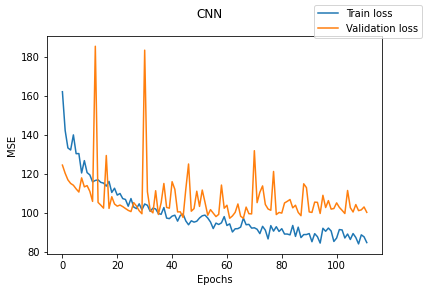

In [13]:
import matplotlib.pyplot as pltn

fig = plt.figure()
plt.plot(cnn_history.history['loss'], label='Train loss')
plt.plot(cnn_history.history['val_loss'], label='Validation loss')
fig.legend()
fig.suptitle('CNN')
plt.xlabel("Epochs")
plt.ylabel("MSE")

plt.show()